<a href="https://colab.research.google.com/github/omrani-wiem/pneumonie-radiographie_/blob/main/radioagraphie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow numpy matplotlib scikit-learn opencv-python


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from google.colab import files
files.upload()  # choisis ton fichier kaggle.json


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"omraniwiem","key":"c222f92e3c4d459f57173d7fe7aa6c65"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
#Vérifier que Kaggle marche bien
!kaggle datasets list -s pneumonia


ref                                                      title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
paultimothymooney/chest-xray-pneumonia                   Chest X-Ray Images (Pneumonia)                       2463365435  2018-03-24 19:41:59.603000         535863       7121  0.75             
pcbreviglieri/pneumonia-xray-images                      Pneumonia X-Ray Images                               1225740412  2020-05-18 14:32:09.660000          11467         98  0.9375           
artyomkolas/3-kinds-of-pneumonia                         3 kinds of Pneumonia                                 3746445760  2022-05-30 19:17:21.597000           2548         37  0.875            
andrewmvd/pediatric-pneumonia-

In [6]:
#Télécharger le dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.26G/2.29G [00:16<00:00, 131MB/s]
100% 2.29G/2.29G [00:16<00:00, 150MB/s]


In [7]:
#extraire le dataset
import zipfile

with zipfile.ZipFile("chest-xray-pneumonia.zip", "r") as zip_ref:
    zip_ref.extractall("/content/dataset")

!ls /content/dataset


chest_xray


In [8]:
#on verifie la structure de données
!ls /content/dataset/chest_xray
!ls /content/dataset/chest_xray/train
!ls /content/dataset/chest_xray/test
!ls /content/dataset/chest_xray/val


chest_xray  __MACOSX  test  train  val
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


In [9]:
#on prepare les dataset avec tensorflow

#remarque tf.keras.utils.image_dataset_from_directory :C’est une fonction de TensorFlow qui crée automatiquement un jeu de données d’images à partir d’un dossier.
#batch_size=batch_size :Le nombre d’images que tu donnes au modèle à chaque étape d’entraînement (mini-lot).Exemple : si batch_size=32, ton dataset fournira des paquets de 32 images à la fois.
import tensorflow as tf

train_dir = "/content/dataset/chest_xray/train"
test_dir = "/content/dataset/chest_xray/test"
val_dir = "/content/dataset/chest_xray/val"

img_height, img_width = 150, 150
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [10]:
# Cellule 1 — Imports + vérification GPU + paramètres
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow version:", tf.__version__)
print("GPUs disponibles :", tf.config.list_physical_devices("GPU"))

# Chemins (ajuste si tu as extrait ailleurs)
DATA_ROOT = "/content/dataset/chest_xray"   # après extraction via Kaggle
TRAIN_DIR = os.path.join(DATA_ROOT, "train")#c'est comme ci on a /content/dataset/chest_xray/train
VAL_DIR   = os.path.join(DATA_ROOT, "val")#/content/dataset/chest_xray/val
TEST_DIR  = os.path.join(DATA_ROOT, "test")#/content/dataset/chest_xray/test

# Hyperparamètres (ajuste si OOM)
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
BASE_MODEL = "efficientnetb0"   # bon compromis performance/vitesse
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)


TensorFlow version: 2.19.0
GPUs disponibles : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# Cellule 2 — Inspect dataset
def count_images(folder):
    folder = Path(folder)
    counts = {}
    for cls in sorted([d for d in folder.iterdir() if d.is_dir()]):
        counts[cls.name] = len(list(cls.rglob("*.jpg"))) + len(list(cls.rglob("*.png"))) + len(list(cls.rglob("*.jpeg")))
    return counts

print("Train exists?", os.path.exists(TRAIN_DIR))
print("Val exists? ", os.path.exists(VAL_DIR))
print("Test exists?", os.path.exists(TEST_DIR))

print("\nTrain counts:", count_images(TRAIN_DIR))
print("Val counts:",   count_images(VAL_DIR))
print("Test counts:",  count_images(TEST_DIR))


Train exists? True
Val exists?  True
Test exists? True

Train counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Val counts: {'NORMAL': 8, 'PNEUMONIA': 8}
Test counts: {'NORMAL': 234, 'PNEUMONIA': 390}


In [12]:
# Cellule 3 — Build datasets
AUTOTUNE = tf.data.AUTOTUNE

def build_datasets(train_dir, val_dir, test_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE, augment=True):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir, image_size=(img_size,img_size), batch_size=batch_size, shuffle=True
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir, image_size=(img_size,img_size), batch_size=batch_size, shuffle=False
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir, image_size=(img_size,img_size), batch_size=batch_size, shuffle=False
    )

    class_names = train_ds.class_names
    print("Class names:", class_names)

    # Normalisation [0,1]
    normalize = layers.Rescaling(1./255)

    if augment:
        data_augmentation = keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.06),
            layers.RandomZoom(0.08),
        ])
    else:
        data_augmentation = None

    def preprocess(x, y, training=False):
        x = normalize(x)
        if training and data_augmentation is not None:
            x = data_augmentation(x, training=True)
        return x, y

    train_ds = train_ds.map(lambda x,y: preprocess(x,y,True), num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x,y: preprocess(x,y,False), num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(lambda x,y: preprocess(x,y,False), num_parallel_calls=AUTOTUNE)

    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

train_ds, val_ds, test_ds, class_names = build_datasets(TRAIN_DIR, VAL_DIR, TEST_DIR, augment=True)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Class names: ['NORMAL', 'PNEUMONIA']


In [13]:
# Cellule 4 — Compute class weights
from collections import Counter

def compute_class_weights_from_dir(train_dir):
    counts = count_images(train_dir)
    classes = sorted(counts.keys())
    total = sum(counts.values())
    n_classes = len(classes)
    weights = {}
    for i, cls in enumerate(classes):
        # weight inversément proportionnel à la fréquence
        weights[i] = total / (n_classes * max(counts[cls], 1))
    return weights, classes, counts

class_weights, classes_ordered, counts = compute_class_weights_from_dir(TRAIN_DIR)
print("Class weights:", class_weights)
print("Classes order:", classes_ordered)
print("Counts:", counts)


Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}
Classes order: ['NORMAL', 'PNEUMONIA']
Counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}


In [14]:
# Cellule 5 — Build model (EfficientNetB0)
from tensorflow.keras import backend as K

def build_model(img_size=IMG_SIZE, base_name="efficientnetb0", dropout_rate=0.3, lr=1e-3, freeze_backbone=True):
    input_shape = (img_size, img_size, 3)
    if base_name.lower() == "efficientnetb0":
        base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")
        last_conv_name = "top_conv"
        preprocess_fn = keras.applications.efficientnet.preprocess_input
    else:
        raise ValueError("Base non prise en charge")

    base_model.trainable = not freeze_backbone

    inputs = keras.Input(shape=input_shape)
    # nos images sont en [0,1] (Rescaling fait dans pipeline). EfficientNet preprocess expects 0-255 -> apply *255 then preprocess_input
    x = layers.Lambda(lambda z: z * 255.0)(inputs)
    x = layers.Lambda(lambda z: preprocess_fn(z))(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # binaire

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
    )
    return model, base_model, last_conv_name

model, base_model, last_conv = build_model(freeze_backbone=True)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
# Cellule 6 — Callbacks + entraînement
ckpt_path = os.path.join(OUT_DIR, "best_model.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)
# Sauvegarde finale
model.save(os.path.join(OUT_DIR, "final_head_model.keras"))


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7528 - auc: 0.8271 - loss: 0.4906 - precision: 0.8943 - recall: 0.7591
Epoch 1: val_auc improved from -inf to 0.98438, saving model to /content/outputs/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 579ms/step - accuracy: 0.7533 - auc: 0.8277 - loss: 0.4899 - precision: 0.8946 - recall: 0.7594 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.3359 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8923 - auc: 0.9667 - loss: 0.2492 - precision: 0.9675 - recall: 0.8862
Epoch 2: val_auc did not improve from 0.98438
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8924 - auc: 0.9667 - loss: 0.2491 - precision: 0.9675 - recall: 0.8863 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2853 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy:

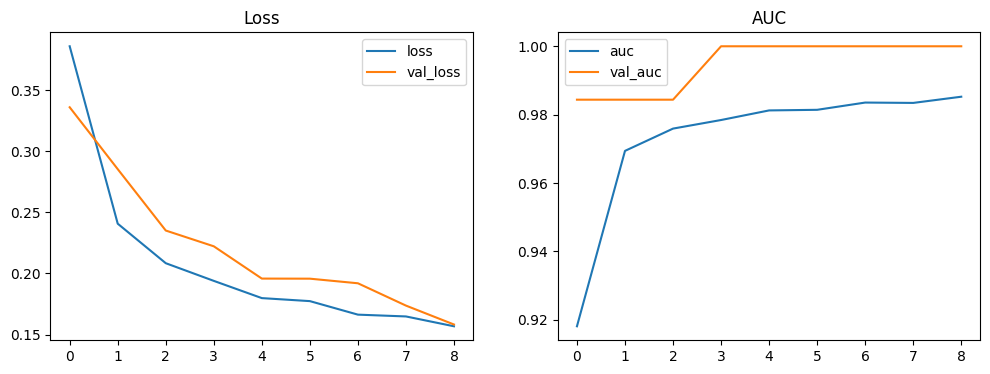

In [16]:
# Cellule 7 — Plots
hist = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.get("loss",[]), label="loss")
plt.plot(hist.get("val_loss",[]), label="val_loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(hist.get("auc",[]), label="auc")
plt.plot(hist.get("val_auc",[]), label="val_auc")
plt.legend(); plt.title("AUC")
plt.show()


In [17]:
# Cellule 8 — Fine-tuning
# Dégeler le backbone partiellement
base_model.trainable = True
# Geler les premières couches (70%) pour ne pas tout détruire
total = len(base_model.layers)
freeze_until = int(total * 0.7)
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False
for layer in base_model.layers[freeze_until:]:
    layer.trainable = True

# Re-compiler avec LR plus petit
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights,
    callbacks=callbacks
)

# Sauvegarder modèle fine-tuned
model.save(os.path.join(OUT_DIR, "final_finetuned_model.keras"))


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8492 - auc: 0.9584 - loss: 0.3083 - precision: 0.9845 - recall: 0.8118
Epoch 1: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 101ms/step - accuracy: 0.8493 - auc: 0.9585 - loss: 0.3081 - precision: 0.9845 - recall: 0.8120 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.2348 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8986 - auc: 0.9794 - loss: 0.2197 - precision: 0.9872 - recall: 0.8763
Epoch 2: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.8987 - auc: 0.9794 - loss: 0.2196 - precision: 0.9872 - recall: 0.8764 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1969 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9271 - auc: 0.9869 - loss: 0.1725 - precision

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 164ms/step - accuracy: 0.8065 - auc: 0.8476 - loss: 0.3989 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2879
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.9163 - auc: 0.9707 - loss: 0.2034 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2059
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.9345 - auc: 0.9802 - loss: 0.1685 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1838
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.9387 - auc: 0.9839 - loss: 0.1524 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1798


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Classification report:
              precision    recall  f1-score   support

      NORMAL     0.8972    0.4103    0.5630       234
   PNEUMONIA     0.7331    0.9718    0.8357       390

    accuracy                         0.7612       624
   macro avg     0.8151    0.6910    0.6994       624
weighted avg     0.7946    0.7612    0.7335       624

Confusion matrix:
 [[ 96 138]
 [ 11 379]]


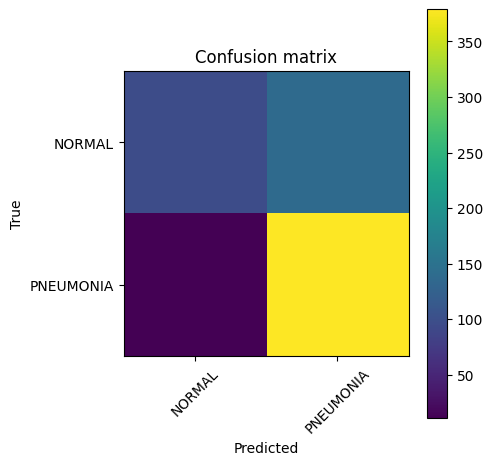

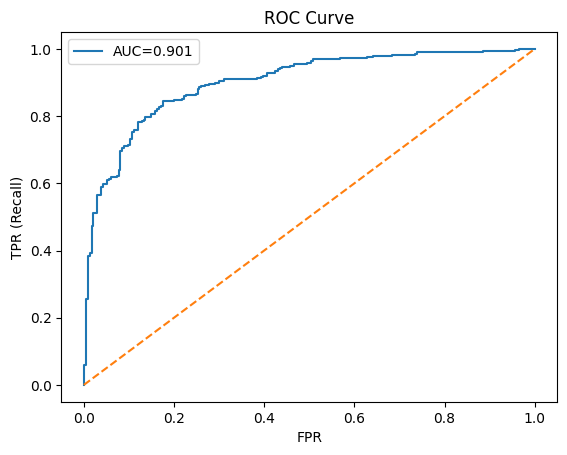

ROC AUC: 0.9007122507122509


In [20]:
# ============================
# 📌 Imports
# ============================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ============================
# 📌 Paramètres globaux
# ============================
IMG_SIZE = 150
BATCH_SIZE = 32
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

train_dir = "/content/dataset/chest_xray/train"
val_dir = "/content/dataset/chest_xray/val"
test_dir = "/content/dataset/chest_xray/test"

# ============================
# 📌 Prétraitement dataset
# ============================
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

def preprocess_for_efficientnet(x, y):
    x = tf.cast(x, tf.float32)
    x = eff_preprocess(x)  # mise à l’échelle et normalisation pour EfficientNet
    return x, y

def make_dataset(dir_path, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE
    )
    class_names = ds.class_names
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(preprocess_for_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE), class_names

# Création des datasets
train_ds, class_names = make_dataset(train_dir, shuffle=True)
val_ds, _ = make_dataset(val_dir, shuffle=False)
test_ds, _ = make_dataset(test_dir, shuffle=False)

print("Classes:", class_names)

# ============================
# 📌 Construction du modèle
# ============================
def build_model(img_size=IMG_SIZE, dropout_rate=0.3, lr=1e-3, freeze_backbone=True):
    input_shape = (img_size, img_size, 3)
    base_model = keras.applications.EfficientNetB0(
        include_top=False, input_shape=input_shape, weights="imagenet"
    )
    base_model.trainable = not freeze_backbone

    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model

# ============================
# 📌 Entraînement avec sauvegarde des poids
# ============================
ckpt_weights = os.path.join(OUT_DIR, "best_weights.weights.h5")  # correction ici

model = build_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_weights, monitor="val_auc", save_best_only=True, save_weights_only=True
    ),
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)

# ============================
# 📌 Reconstruction du modèle + chargement poids
# ============================
best_model = build_model()
best_model.load_weights(ckpt_weights)

# ============================
# 📌 Évaluation
# ============================
y_true, y_prob = [], []

for x_batch, y_batch in test_ds:
    preds = best_model.predict(x_batch, verbose=0)
    y_prob.extend(preds.reshape(-1).tolist())
    y_true.extend(y_batch.numpy().tolist())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Matrice de confusion
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"))
plt.show()

# ROC AUC
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, thr = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "roc_curve.png"))
plt.show()
print("ROC AUC:", auc)


In [21]:
# Cellule 10 — Threshold tuning (maximize F1)
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.linspace(0.0, 1.0, 101)
best_t = 0.5
best_f1 = 0.0
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_true, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t
print(f"Best threshold by F1: {best_t:.3f} → F1={best_f1:.4f}")
# If you need to favor recall, compute recall per threshold similarly.


Best threshold by F1: 0.750 → F1=0.8686


In [32]:
# ============================
# Cellule 11 — Grad-CAM final corrigée
# ============================
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras import layers
import os

# ============================
# Paramètres
# ============================
IMG_SIZE = 150
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)
test_dir = "/content/dataset/chest_xray/test"

# ============================
# Fonctions utilitaires
# ============================
def load_img_array(path, img_size=IMG_SIZE):
    img = keras.utils.load_img(path, target_size=(img_size, img_size))
    arr = keras.utils.img_to_array(img)
    arr = preprocess_input(arr)  # prétraitement manuel
    return np.expand_dims(arr, axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if predictions.shape[-1] == 1:  # binary classification
            loss = predictions[:, 0]
        else:  # multi-class classification
            loss = predictions[:, tf.argmax(predictions[0])]

    # Extract filters and gradients
    grads = tape.gradient(loss, conv_outputs)

    # Pool gradients across spatial dimensions (height and width)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_and_save(original_img_path, heatmap, out_path, alpha=0.4):
    img = cv2.imread(original_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, alpha, img, 1-alpha, 0)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis('off'); plt.title("Grad-CAM")
    plt.savefig(out_path, dpi=160)
    plt.show()

# ============================
# Préparer le modèle pour Grad-CAM
# ============================
# First, let's find the right convolutional layer
# Print model summary to see layer names
best_model.summary()

# Look for the last convolutional layer in the EfficientNet base
# Typically it's something like 'top_conv' or the last conv layer before global average pooling
# If you can't find it, try these common names:
last_conv_layer_name = None
for layer in best_model.layers:
    if 'conv' in layer.name and isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        print(f"Found convolutional layer: {layer.name}")

# If no conv layer found, try to find the EfficientNet base model
if last_conv_layer_name is None:
    for layer in best_model.layers:
        if hasattr(layer, 'layers'):  # This is a nested model (like EfficientNet base)
            for sublayer in layer.layers:
                if 'conv' in sublayer.name and isinstance(sublayer, tf.keras.layers.Conv2D):
                    last_conv_layer_name = f"{layer.name}/{sublayer.name}"
                    print(f"Found convolutional layer in submodel: {last_conv_layer_name}")

# If still not found, use a common name for EfficientNet's last conv layer
if last_conv_layer_name is None:
    last_conv_layer_name = "top_conv"  # Common name for EfficientNet's last conv layer

print(f"Using layer: {last_conv_layer_name} for Grad-CAM")

# ============================
# Sélection de quelques images de test
# ============================
sample_dir = os.path.join(test_dir, "PNEUMONIA")  # ou "NORMAL"
sample_files = list(Path(sample_dir).glob("*.jpeg"))[:4]  # 4 exemples

# ============================
# Générer Grad-CAM
# ============================
for i, p in enumerate(sample_files):
    try:
        img_array = load_img_array(str(p))
        heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name)
        outp = os.path.join(OUT_DIR, f"gradcam_{i}.png")
        overlay_and_save(str(p), heatmap, outp)
        print("Saved:", outp)
    except Exception as e:
        print(f"Error processing {p}: {e}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,416 (15.46 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2,564 (10.02 KB)

Found convolutional layer in submodel: efficientnetb0/stem_conv
Found convolutional layer in submodel: efficientnetb0/block1a_project_conv
Found convolutional layer in submodel: efficientnetb0/block2a_expand_conv
Found convolutional layer in submodel: efficientnetb0/block2a_project_conv
Found convolutional layer in submodel: efficientnetb0/block2b_expand_conv
Found convolutional layer in submodel: efficientnetb0/block2b_project_conv
Found convolutional layer in submodel: efficientnetb0/block3a_expand_conv
Found convolutional layer in submodel: efficientnetb0/block3a_project_conv
Found convolutional layer in submodel: efficientnetb0/block3b_expand_conv
Found convolutional layer in submodel: efficientnetb0/block3b_project_conv
Found convolutional layer in submodel: efficientnetb0/block4a_expand_conv
Found convolutional layer in submodel: efficientnetb0/block4a_project_conv
Found convolutional layer in submodel: efficientnetb0/block4b_expand_conv
Found convolutional layer in submodel: eff

In [33]:
# Cellule 12 — Gradio demo (optionnel dans Colab)
!pip install -q gradio

import gradio as gr

def predict_image(img):
    # img: PIL image
    arr = np.array(img).astype("float32") / 255.0
    arr = cv2.resize(arr, (IMG_SIZE, IMG_SIZE))
    inp = np.expand_dims(arr, axis=0)
    prob = float(best_model.predict(inp)[0,0])
    return {"prob_malade": prob, "prob_sain": 1-prob}

demo = gr.Interface(fn=predict_image, inputs=gr.Image(type="pil"), outputs=[gr.Label(num_top_classes=2)])
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dd8ef1147df5a8f338.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
